In [1]:
!pip install wget
import wget
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Nun betrachten wir einen Datensatz mit Hunden und Katzen.

In [2]:
classes = ['Cat', 'Dog']

Zuerst laden wir den präparierten Datensatz herunter und entpacken diesen.

In [3]:
if not os.path.isdir("data/PetImages"):
    wget.download("https://oshi.at/zQWKNV", bar=wget.bar_adaptive)

    import zipfile
    with zipfile.ZipFile("flbF.zip", "r") as zip_ref:
        zip_ref.extractall("")

In [4]:
train_path = 'data/PetImages/train'
valid_path = 'data/PetImages/valid'
test_path = 'data/PetImages/test'

Nun erzeugen wir aus den Ordnern die zugehörigen Batches.
`tf.keras.applications.vgg16.preprocess_input` passt hierbei den Input
noch für das neuronale Netz an.
`flow_from_directory` erzeugt augmentierte Bilder.
In unserem Beispiel werden diese einfach auf die Größe `256x256` skaliert.

In [5]:
image_size = 256
batch_size = 10

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path,
                         target_size=(image_size, image_size),
                         classes=classes,
                         batch_size=batch_size)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path,
                         target_size=(image_size, image_size),
                         classes=classes,
                         batch_size=batch_size)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path,
                         target_size=(image_size, image_size),
                         classes=classes,
                         batch_size=batch_size, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
assert train_batches.n == 2*500
assert valid_batches.n == 2*200
assert test_batches.n == 2*50
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [7]:
import matplotlib.pyplot as plt

def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Sehen wir uns das erste Trainingsbatch kurz an.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

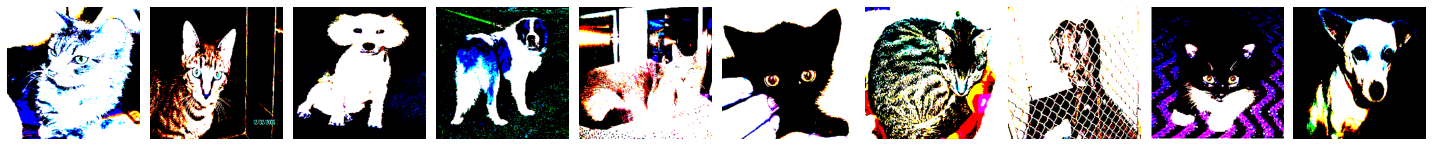

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [8]:
imgs, labels = next(train_batches)

plot_images(imgs)
print(labels)

Nun kommen wir endlich zu unserem neuronalen Netz.
Wir verwenden ein Convolutional Neural Network, das durch `tf.keras.models.Sequential`
realisiert und verwendet zwei `tf.keras.layers.Conv2D`-Ebenen, zwei `tf.keras.layers.MaxPool2D`-Ebenen
und zum Schluss noch ein Fully-connected Layer, welches wir durch `tf.keras.layers.Flatten`
und `tf.keras.layers.Dense` bekommen.

In [12]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)),
    MaxPool2D(pool_size=(4,4), strides=4),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax'),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 65538     
Total params: 75,682
Trainable params: 75,682
Non-trainable params: 0
__________________________________________________

Für unsere Loss-Funktion verwenden wir Categorical Crossentropy
und für den Optimierer verwenden wir `tf.keras.optimizers.Adam`,
da dieser bessere Ergebnisse als Stochastic Gradient Descent liefert.

In [13]:
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Mit `fit()` trainieren wir das neuronale Netz.

In [ ]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=2, verbose=2)

Epoch 1/2


Betrachten wir nun das Test-Set.
Da das Test-Set nicht gemischt wurde,
sind die ersten Bilder alles Katzen.

In [ ]:
test_imgs, test_labels = next(test_batches)
plot_images(test_imgs)
print(test_labels)

Nun sagen wir das Test-Set mithilfe unseres trainierten Netzes mit `predict()` vor.

In [ ]:
predictions = model.predict(x=test_batches, verbose=0)

In [ ]:
import numpy as np
preds = np.argmax(predictions, axis=1)
print("Predictions:\n", preds)
print("Actual:\n", test_batches.classes)
print("Accuracy:", sum(preds == test_batches.classes)/preds.shape[0])